## Welcome to Day 12 - Hands On!

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

Pada latihan kali ini, kita akan belajar teknik-tenik yang lebih mutakhir dalam melakukan Exploratory Data Analysis dan Data Processing di Pandas. Kali ini, kita akan belajar menggunakan `titanic_dataset`, dataset populer yang sering dijadikan landasan untuk belajar Data Science oleh pemula. Namun, kita akan mencoba melakukan beberapa teknik-tenik EDA yang cukup 'intermediate' dibandingkan teknik-tenik pada Day 11. 

In [2]:
df = pd.read_csv('titanic_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- PassengerID: nomor ID dari setiap penumpang, hanya tanda pengenal saja
- Survived: 0 berarti 'tidak selamat', 1 berarti 'selamat'
- Pclass: kelas tiket, 1 = kelas 1 (paling mewah), 2 = kelas 2, 3 = kelas 3 (paling rendah)
- Sex: jenis kelamin
- Age: usia
- SibSp: berapa banyak sibling/spouses yang ikut serta di dalam Titanic
- Parch: berapa banyak parents/children yang ikut serta di dalam Titanic
- Ticket: nomor tiket
- Fare: uang yang dibayarkan (biaya) untuk perjalanan
- Cabin: nomor kabin
- Embarked: kota keberangkatan, C = Cherbourg, Q = Queenstown, S = Southampton

### Part 1: Handling Missing Values

Dapat kita lihat dari `df.info()` bahwa terdapat 3 kolom dengan missing values, yaitu `Age`, `Embarked`, dan `Cabin`. 

##### Rule Of Thumb: Ask The Data Provider!

Jika teman-teman sekalian sudah bekerja menjadi Data Scientist, maka hal pertama yang harus dilakukan ketika menemukan missing values adalah mengkonfirmasikannya kepada pemberi datanya (bisa berupa Business Stakeholder, atau Data Engineer). Bisa saja data yang hilang itu diakibatkan oleh adanya kesalahan dalam proses ingestion, sehingga mereka dapat mengetahui adanya gangguan dalam sistem. 

Atau, bisa saja data yang hilang itu terjadi akibat error dalam 'saving the file', dan semestinya data tersebut ada di file originalnya (dengan demikian, mereka dapat mengambil file original tersebut dan memberikannya ke Data Scientist). 

Intinya, jika ada missing values, kita semestinya mengkomunikasikan hal ini kepada stakeholder yang memberikan kita dataset tersebut, dan meluruskan apa yang harus dilakukan. Jika memang tidak ada yang dapat dilakukan, maka barulah kita dapat mencoba beberapa opsi yang akan kita pelajari di bawah ini.

#### Method 1: Drop the Column

Jika kolom tersebut memiliki banyak missing values (lebih dari 50-60%), maka sulit rasanya bisa mendapatkan metode imputasi yang akurat. Apalagi, jika kolom tersebut dirasa memiliki informasi yang minim. 

Jika hal ini terjadi, maka hal yang dapat dilakukan adalah menghilangkan seluruh kolom (tidak menggunakan kolom tersebut dalam EDA / Modelling). Hal ini yang akan kita lakukan kepada kolom `Cabin`. 

In [4]:
df.drop('Cabin', axis = 'columns', inplace = True)

In [5]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

Kolom `Cabin` sudah tidak ada di dataframe kita^.

#### Method 2: Remove the Rows

Apabila missing values kurang dari 50%, maka hal yang dapat dilakukan adalah menghilangkan semua baris dengan missing values. Ini adalah metode yang paling 'mudah', namun memiliki beberapa konsekuensi:
- Kehilangan informasi dari kolom lain yang penting (dalam kebanyakan kasus, baris yang dihilangkan itu sebenarnya tidak bermasalah di kolom-kolom lain)
- Dataset size menjadi sedikit, bila yang dihilangkan cukup banyak 

In [6]:
df_update = df.dropna(axis = 0).reset_index(drop = True)

In [7]:
df_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 61.3+ KB


<AxesSubplot:xlabel='Age', ylabel='Count'>

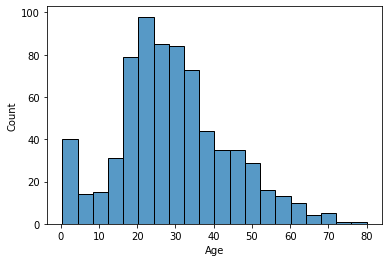

In [8]:
sns.histplot(data = df_update, x = 'Age')

Di atas adalah bentuk histogram dari kolom 'Age' bila kita menghilangkan baris yang memiliki missing values.

#### Method 3: Mengisi dengan Mean/Median dan Modus

Metode imputasi dengan `mean/median` dan `modus` adalah salah satu metode pengisian nilai missing-values. Dalam kasus ini, missing values tidak dihilangkan, namun dicoba dicari nilai-nilai yang 'masuk akal' untuk mengisi values-values yang hilang ini. 

Untuk kolom numerik, biasanya diisi dengan:
- mean, jika kolom tidak memiliki outlier 
- median, jika kita tidak bisa meyakinkan bahwa koom tersebut tidak memiliki outlier

Untuk kolom kategorikal, biasanya diisi dengan modus (nilai yang paling sering muncul). 

In [9]:
df_update = df.copy()
df_update['Age'] = df_update['Age'].fillna(df_update['Age'].median())
df_update['Embarked'] = df_update['Embarked'].fillna(df_update['Embarked'].mode()[0])

In [10]:
df['Age'].median()

28.0

In [11]:
df_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


Konsekuensinya, nilai yang diisi tidak akan terlihat 'natural', apalagi pada kolom yang memiliki banyak missing values. Contohnya adalah pada kolom `Age` berikut ini:

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='Age', ylabel='Count'>

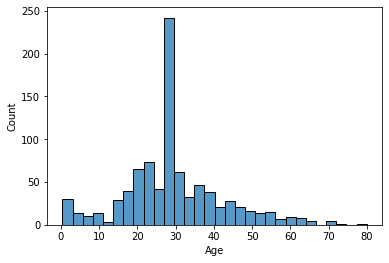

In [13]:
sns.histplot(data = df_update, x = 'Age')

Pada histogram, terlihat bahwa nilai '28.0' yang merupakan nilai `median` menjadi sangat dominan, karena seluruh `missing values` disamaratakan menjadi 28. 

#### Method 4: Regression-Based Imputation

Metode ini digunakan pada kolom numerik. Metode ini menggunakan konsep Regression yang belum dipelajari. Regression sendiri baru dipelajari di day-day berikutnya.

Namun, secara konsep, kita melakukan 'prediksi' pada nilai-nilai 'missing values' menggunakan fakta-fakta dari kolom-kolom lain. 

Maksudnya bagaimana?

Contoh sederhana: 
- Rumah dengan luas 120 meter persegi memiliki harga 4 Miliar
- Rumah dengan luas 150 meter persegi memiliki harga 5 Miliar
- Maka rumah dengan luas 90 meter persegi memiliki harga ??

Estimasi kita pasti menjawab 3 Miliar, bukan?

Nah, kira-kira regression-based estimation adalah seperti itu. 

In [14]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

Mari kita menebak missing-values pada kolom `Age` dengan bantuan kolom-kolom `Pclass`, `SibSp`, `Parch`, dan `Fare`.

In [15]:
from sklearn.linear_model import LinearRegression
### Membuat sebuah LinearRegression
lr = LinearRegression()

### Seleksi kolom-kolom yang digunakan
selected_cols = ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']

### Bagi menjadi Missing dan Training. Missing Df berisi baris-baris dengan 'Age' kosong.
missing_df = df[df['Age'].isnull()==True][selected_cols]
training_df = df[df['Age'].isnull()==False][selected_cols]

### Buatlah model regression dari baris-baris yang tidak memiliki missing values
y_train = training_df['Age']
x_train = training_df.drop('Age', axis = 1)

lr.fit(x_train, y_train)

### Prediksilah nilai 'Age' pada baris-baris yang memiliki missing values
x_missing = missing_df.drop('Age', axis = 1)

prediction = lr.predict(x_missing)
missing_df['Age'] = prediction

In [16]:
### Combine all into one dataframe
df_full = pd.concat([training_df, missing_df])
df_full = df_full.sort_index()
df_full

,Age,Pclass,SibSp,Parch,Fare
0,22.00000,3,1,0,7.2500
1,38.00000,1,1,0,71.2833
2,26.00000,3,0,0,7.9250
3,35.00000,1,1,0,53.1000
4,35.00000,3,0,0,8.0500
...,...,...,...,...,...
886,27.00000,2,0,0,13.0000
887,19.00000,1,0,0,30.0000
888,21.00954,3,1,2,23.4500
889,26.00000,1,0,0,30.0000


In [17]:
df_update = df.copy()
df_update[selected_cols] = df_full[selected_cols]

In [18]:
df_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


<AxesSubplot:xlabel='Age', ylabel='Count'>

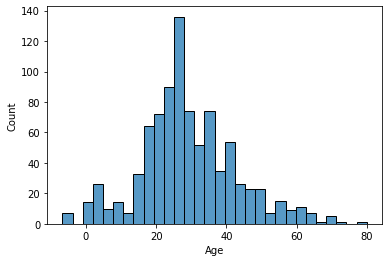

In [19]:
sns.histplot(data = df_update, x = 'Age')

Meskipun hasil imputasi ini masih terlihat tidak natural (ada spike di usia 20an), setidaknya lebih 'natural' daripada hanya mengisi dengan `median/mean`. 

##### Warning: Issue of Multicolinearity

Berhati-hatilah menggunakan metode ini. Metode ini terlihat 'canggih', namun memiliki sebuah konsekuensi yang cukup penting diingat:
- Hasil imputasi akan memiliki korelasi yang tinggi dengan kolom-kolom 'penebak' (karena kita menebak 'Age' berdasarkan nilai-nilai kolom-kolom 'Penebak')
- Padahal, sebuah asumsi 'linear regression' adalah bahwa tidak terdapat korelasi yang tinggi antar kolom-kolom (artinya, seharusnya antarkolom tidak memiliki hubungan yang erat)
- Kesannya, kolom 'Age' sangat dipengaruhi oleh kolom 'Pclass', 'SibSp', (yang kita gunakan untuk menebak). Padahal, belum tentu mereka ini saling berhubungan! Dan dengan mengimputasi seperti ini, kita seakan-akan memaksakan hubungan ini. Jika sebenarnya kolom 'Age' ini tidak memiliki hubungan dengan kolom-kolom 'Pclass', 'SibSp', dst, maka metode imputasi ini bisa dibilang keliru. 

#### Conclusion: No Easy Way

There is no correct 100% working way to deal with missing values. Tidak ada satu pun cara yang dapat dianggap sebagai 'cara paling benar' dalam berhadapan dengan missing values. Lakukanlah eksperimen dan catat hasilnya, untuk menemukan cara terbaik dalam menangani 'missing values'. 

### Part 2: Lambda Apply and Its Alternatives

Kita bisa menggunakan `apply` untuk mengaplikasikan suatu fungsi terhadap sebuah kolom di dataframe. Contoh, kita ingin membuat sebuah kolom baru berisi pengelompokkan usia sebagai berikut:
- Usia 0 - 10: Kids
- Usia 10 - 20: Teens
- Usia 20 - 30: Young Adult
- Usia 30 - 50: Adult
- Usia >50: Old

In [36]:
def age_classifier(x):
    if x < 11:
        return 'Kid'
    elif x < 21:
        return 'Teen'
    elif x < 31:
        return 'Young Adult'
    elif x < 51:
        return 'Adult'
    else:
        return 'Old'

In [37]:
%%time
df['AgeClass'] = df['Age'].apply(age_classifier)

Wall time: 1 ms


(Operasi di atas memakan waktu 1 milisecond)

In [24]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeClass
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Adult


Bagaimana jika fungsi kita cukup 'singkat'? Misalnya, kita ingin melakukan pembulatan pada kolom `Fare`. Maka, kita tidak perlu menulis sebuah fungsi baru terlebih dahulu.

In [34]:
%%time
df['FareRound'] = df['Fare'].apply(lambda x: np.round(x))

Wall time: 5.01 ms


In [30]:
df[['PassengerId', 'Fare', 'FareRound']].head(5)

,PassengerId,Fare,FareRound
0,1,7.2500,7.0
1,2,71.2833,71.0
2,3,7.9250,8.0
3,4,53.1000,53.0
4,5,8.0500,8.0


Namun, hal ini bukanlah yang paling 'cepat'. Dalam dataset yang memiliki ukuran yang besar (jutaan baris), sebisa mungkin, hindari penggunaan `apply`, dan perbanyaklah penggunaan `numpy` secara langsung. Hal ini karena operasi `apply` lebih tidak efisien daripada operasi menggunakan `numpy` secara langsung.

In [35]:
%%time
df['FareRound'] = np.round(df['Fare'])

Wall time: 0 ns


Bagaimana dengan `apply` sebuah `function`? Gunakan `np.vectorize`.

In [38]:
%%time
df['AgeClass'] = np.vectorize(age_classifier)(df['Age'])

Wall time: 0 ns


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Menggunakan `apply`, kita memakan waktu beberapa milisecond. Ya, masih sangat singkat. Tapi, tanpa menggunakan `apply`, kita memakan waktu 0 nanosecond, lebih singkat lagi. Jika dataset kita besar (puluhan juta baris), maka hal ini akan menjadi 'game-changer'.

### Part 3: Cross Tabulation

Cross Tabulation adalah sebuah cara melihat data 'keseluruhan' dengan menjumlahkan kemudian mengelompokkan data berdasarkan dua kolom kategorikal. Contohnya adalah sebagai berikut:

In [42]:
pd.crosstab(df['Sex'], df['Embarked'])

Embarked,C,Q,S
Sex,,,
female,73,36,203
male,95,41,441


In [43]:
pd.crosstab(df['Embarked'], df['Sex'])

Sex,female,male
Embarked,,
C,73,95
Q,36,41
S,203,441


Bagaimana jika kita ingin mengetahui, misalnya:
- Median dari UMUR (AGE) penumpang...
- ...dipisahkan berdasarkan Jenis Kelamin (SEX) dan kota keberangkatan (EMBARKED)

Jawabannya adalah `pivot_table`

In [50]:
pd.pivot_table(df, values = 'Age', index = ['Sex'], columns = ['Embarked'], aggfunc = np.median)

Embarked,C,Q,S
Sex,,,
female,24.0,21.5,27.0
male,30.0,30.0,28.0


Bagaimana jika kita ingin mengetahui, misalnya:
- Usia penumpang paling tua...
- ...dipisahkan berdasarkan Jenis Kelamin (SEX) dan kota keberangkatan (EMBARKED)

In [51]:
pd.pivot_table(df, values = 'Age', index = ['Sex'], columns = ['Embarked'], aggfunc = np.max)

Embarked,C,Q,S
Sex,,,
female,60.0,39.0,63.0
male,71.0,70.5,80.0


Kita tinggal mengganti `aggfunc` dari `median` menjadi `max`. Dari sini, kita dapat melihat bahwa untuk kota keberangkatan Queenstown, usia penumpang wanita paling tua adalah 39 tahun, jauh di bawah usia penumpang tertua di kota-kota lain.

### Part 4: Group-By Aggregation

Group-By adalah cara melakukan agregasi berdasarkan pengelompokkan dari kolom-kolom tertentu. Memang, ini terkesan mirip dengan `pivot_table`. Namun, cara penyajian datanya adalah secara vertikal, bukan horizontal.

Misalnya, kita ingin mengetahui, "Apabila dikelompokkan berdasarkan jenis kelamin dan rentang usia, berapa rata-rata biaya yang dikeluarkan penumpang untuk berlayar di Titanic?"

In [55]:
df.groupby(['Sex', 'AgeClass'])['Fare'].mean()

Sex     AgeClass   
female  Adult          60.825442
        Kid            27.849326
        Old            38.406013
        Teen           40.659063
        Young Adult    41.151626
male    Adult          32.084198
        Kid            32.862879
        Old            23.534233
        Teen           21.897560
        Young Adult    21.105114
Name: Fare, dtype: float64

Kita dapat melihat bahwa biaya rata-rata paling murah dikeluarkan oleh demografi `Young Adult Male`, dan biaya paling mahal dikeluarkan oleh demografi `Adult Female`.